In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import numpy as np
from PIL import Image
from os.path import join, isfile
from os import listdir
from tensorflow import lite
from keras import layers
from keras.models import Sequential


In [2]:
def zero_pad_num(num, length):
    result_string = num.__str__() + ".jpg"
    pads = length - (math.log(num + 1, 10)).__int__()
    if pads == 0:
        return result_string
    for j in range(pads):
        result_string = "0" + result_string
    return result_string


def crop_images(source_path, destination_path):
    base_path = os.getcwd()

    rank_path = base_path + source_path
    rank_dst = base_path + destination_path
    rank_dims = 5, 5, 35, 63 # left, top, right, bottom

    if not os.path.isdir(rank_dst):
        os.mkdir(rank_dst)

    rank_paths = []
    rank_labels = []

    for path in os.listdir(rank_path):
        if os.path.isdir(os.path.join(rank_path, path)):
            rank_paths.append(os.path.join(rank_path, path))
            rank_labels.append(path)

    for index in range(len(rank_paths)):
        path = rank_paths[index]
        onlyfiles = [join(path, file) for file in listdir(path) if isfile(join(path, file)) and file != "desktop.ini"]
        for j in range(len(rank_labels)):
            if not os.path.isdir(rank_dst + "\\" + rank_labels[j]):
                os.mkdir(rank_dst + "\\" + rank_labels[j])


        id_length = (math.log(len(onlyfiles), 10)).__int__()
        for j in range(len(onlyfiles)):
            image_to_crop = Image.open(onlyfiles[j])
            image = image_to_crop.crop(rank_dims)
            image.save(join(rank_dst + "\\" + rank_labels[index], zero_pad_num(j, id_length)))
            image_to_crop.close()

In [3]:
crop_images("\\data\\rank", "\\data\\cropped_rank")

In [4]:
batch_size = 16
img_height = 58
img_width = 30

data_dir = os.getcwd() + "\\data\\cropped_rank"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 25313 files belonging to 14 classes.
Using 20251 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25313 files belonging to 14 classes.
Using 5062 files for validation.


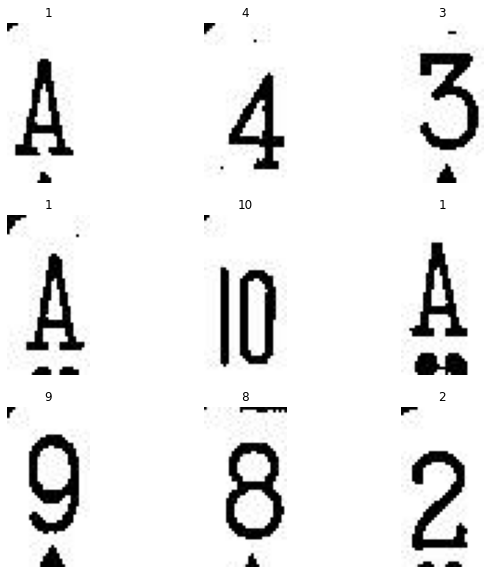

In [6]:
#See if images are there.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [7]:
class_names = ['na', 'ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen',
               'king']

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(16, 58, 30, 3)
(16,)


In [9]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [10]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height,
                                            img_width,
                                            3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 58, 30, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 15, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 7, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 7, 64)         1

In [13]:
epochs = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
1266/1266 [==============================] - 35s 17ms/step - loss: 0.1414 - accuracy: 0.9590 - val_loss: 0.0215 - val_accuracy: 0.9953
Epoch 2/8
1266/1266 [==============================] - 15s 11ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0121 - val_accuracy: 0.9996
Epoch 3/8
1266/1266 [==============================] - 14s 11ms/step - loss: 5.7567e-05 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 0.9994
Epoch 4/8
1266/1266 [==============================] - 14s 11ms/step - loss: 3.0549e-06 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9996
Epoch 5/8
1266/1266 [==============================] - 14s 11ms/step - loss: 1.4881e-06 - accuracy: 1.0000 - val_loss: 0.0142 - val_accuracy: 0.9996
Epoch 6/8
1266/1266 [==============================] - 13s 11ms/step - loss: 8.6679e-07 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9996
Epoch 7/8
1266/1266 [==============================] - 13s 11ms/step - loss: 5.0266e-07 - accuracy: 1.0000 - val_l

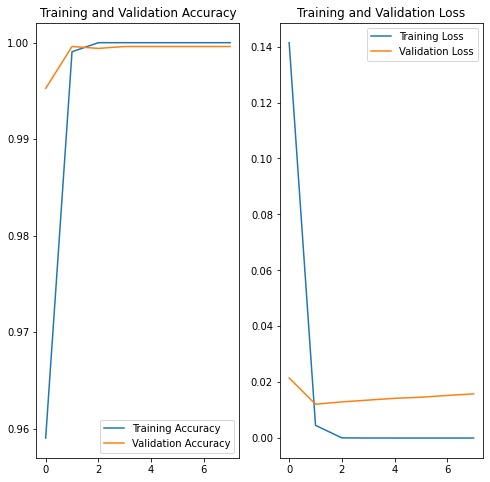

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
def test_model(mdl):
    test_data = "\\data\\test_images_rank"
    cropped_test_data = "\\data\\test_images_rank_cropped"
    crop_images(test_data, cropped_test_data)
    cropped_test_data = os.getcwd() + cropped_test_data

    paths = []
    path_labels = []

    for path in os.listdir(cropped_test_data):
        if os.path.isdir(os.path.join(cropped_test_data, path)):
            paths.append(os.path.join(cropped_test_data, path))
            path_labels.append(path)

    total_predictions = 0
    total_correct_predictions = 0
    collected_confidences = []

    for index in range(len(paths)):
        correct_predictions = 0
        confidences = []
        path_label = paths[index]
        onlyfiles = [join(path_label, file) for file in listdir(path_label) if
                     isfile(join(path_label, file)) and file != "desktop.ini"]

        for path in onlyfiles:
            img = tf.keras.utils.load_img(
                path, target_size=(img_height, img_width)
            )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)  # Create a batch

            predictions = mdl.predict(img_array)
            score = tf.nn.softmax(predictions[0])
            if np.argmax(score) == index + 1: # Offset, as background is not in test data
                correct_predictions += 1
                total_correct_predictions += 1
                confidences.append(100 * np.max(score))
                collected_confidences.append(100 * np.max(score))
        total_predictions += len(onlyfiles)
        print("{} correct predictions of suit {} out of {} predictions. Ratio: {:.2f}".format(
            correct_predictions,
            path_labels[index],
            len(onlyfiles),
            (correct_predictions.__float__() / len(onlyfiles).__float__())
            )
        )
        print("Confidence statistics on correct prediction ({}):".format(path_labels[index]))
        print("Minimum confidence: {:.2f}".format(np.min(confidences)))
        print("Maximum confidence: {:.2f}".format(np.max(confidences)))
        print("Average confidence: {:.2f}".format(np.average(confidences)))
    print("{} correct predictions of all {} predictions. Ratio: {:.2f}".format(
            total_correct_predictions,
            total_predictions,
            (total_correct_predictions.__float__() / total_predictions.__float__())
            )
        )
    print("Confidence statistics on correct prediction (all suits):")
    print("Minimum confidence: {:.2f}".format(np.min(collected_confidences)))
    print("Maximum confidence: {:.2f}".format(np.max(collected_confidences)))
    print("Average confidence: {:.2f}".format(np.average(collected_confidences)))
test_model(model)

88 correct predictions of suit 01 out of 88 predictions. Ratio: 1.00
Confidence statistics on correct prediction (01):
Minimum confidence: 100.00
Maximum confidence: 100.00
Average confidence: 100.00
90 correct predictions of suit 02 out of 90 predictions. Ratio: 1.00
Confidence statistics on correct prediction (02):
Minimum confidence: 100.00
Maximum confidence: 100.00
Average confidence: 100.00
159 correct predictions of suit 03 out of 159 predictions. Ratio: 1.00
Confidence statistics on correct prediction (03):
Minimum confidence: 88.98
Maximum confidence: 100.00
Average confidence: 99.88
165 correct predictions of suit 04 out of 165 predictions. Ratio: 1.00
Confidence statistics on correct prediction (04):
Minimum confidence: 83.45
Maximum confidence: 100.00
Average confidence: 99.90
147 correct predictions of suit 05 out of 147 predictions. Ratio: 1.00
Confidence statistics on correct prediction (05):
Minimum confidence: 92.44
Maximum confidence: 100.00
Average confidence: 99.95


In [16]:
model.save(os.getcwd() + "\\model\\rank_model")

INFO:tensorflow:Assets written to: C:\Users\ablaz\Dropbox\Universitet\DTU\F22\62410-cdio-project\SolitaireCDIO\python\model\rank_model\assets


In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model(os.getcwd() + "\\model\\rank_model")
tflite_model = converter.convert()

with open(os.getcwd() + "\\model\\rank_model\\tflite_rank_model.tflite", 'wb') as f: f.write(tflite_model)



In [18]:
keras_file = os.getcwd() + "\\model\\rank_model\\keras\\rank.h5"
tf.keras.models.save_model(model, keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open(os.getcwd() + "\\model\\rank_model\\keras\\rank.tflite", "wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ablaz\AppData\Local\Temp\tmpjlro37ff\assets


793660